## This example show the ability of CNN with encoder-decoder architecture to approximate complex media data with periodic component.  

#### As data source gif-file with Menhera manga character was used. Gif-file contains 10 frames (3 channel RGB images). Resolution of images was reduced to 45x45 pixels to light the task.

![SegmentLocal](tools/media/anime_10f_fullsize.gif "segment")

#### Function to prepare dataset from gif-file to numpy matrices  

In [2]:
import numpy as np
from PIL import Image, ImageSequence

def get_anime_timeseries(rgb=True):
    with Image.open('tools/media/anime_10f.gif') as im:
        array = []
        for frame in ImageSequence.Iterator(im):
            if rgb:
                im_data = frame.copy().convert('RGB').getdata()
                im_array = np.array(im_data).reshape(frame.size[1], frame.size[0], 3)
            else:
                im_data = frame.copy().convert('L').getdata()
                im_array = np.array(im_data).reshape(frame.size[1], frame.size[0], 1)
            array.append(im_array)
        array = np.array(array)        
        array = array/255
    return array


def get_cycled_data(cycles_num, is_rgb):
    array = get_anime_timeseries(rgb=is_rgb)
    arr = []
    for i in range(cycles_num):
        arr.append(array)
    arr = np.array(arr)
    arr = arr.reshape(arr.shape[0]*arr.shape[1], arr.shape[2], arr.shape[3], arr.shape[4])
    return arr

### Train / test set initialization

Train shape: (50, 45, 45)
Test shape: (10, 45, 45)


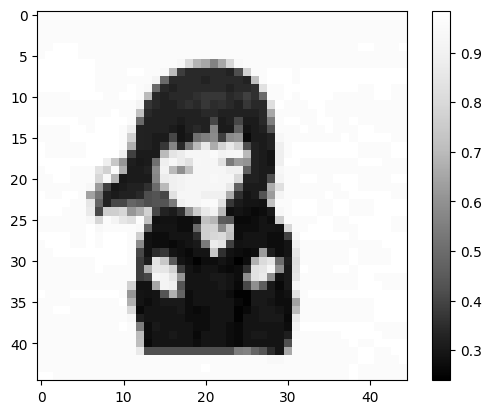

In [4]:
import matplotlib.pyplot as plt

train = get_cycled_data(5, is_rgb=False)[:, :, :, 0]
print(f'Train shape: {train.shape}')
test = get_cycled_data(1, is_rgb=False)[:, :, :, 0]
print(f'Test shape: {test.shape}')


plt.imshow(train[3], cmap='Greys_r')
plt.colorbar()
plt.show()

In [5]:
from torchcnnbuilder.preprocess.time_series import multi_output_tensor, single_output_tensor

train_dataset = multi_output_tensor(data=train,
                                    pre_history_len=20,
                                    forecast_len=10)
test_dataset = single_output_tensor(data=test, 
                                   forecast_len=10)

In [6]:
for i, batch in enumerate(train_dataset):
    print(f'batch number: {i}',
          f'X shape: {batch[0].shape}\nY shape: {batch[1].shape}',
          sep='\n',
          end='\n\n')
    break
print(f'Dataset len (number of batches/X-windows): {len(train_dataset)}')
for i, batch in enumerate(test_dataset):
    print(f'X shape: {batch[0].shape}\nY shape: {batch[1].shape}',
          end='\n\n')

print(f'Dataset len (number of batches/X-windows): {len(test_dataset)}')

batch number: 0
X shape: torch.Size([20, 45, 45])
Y shape: torch.Size([10, 45, 45])

Dataset len (number of batches/X-windows): 20
X shape: torch.Size([0, 45, 45])
Y shape: torch.Size([10, 45, 45])

Dataset len (number of batches/X-windows): 1


In [41]:


import torch
import torch.optim as optim
from torch.utils.data import DataLoader

# using ssim as loss and score metric (firstly you need to pip install it)
from pytorch_msssim import ssim

# time-series preprocessing



  0%|          | 0/100000 [00:00<?, ?it/s]

epoch : 10001/100000, recon loss = 0.07550365


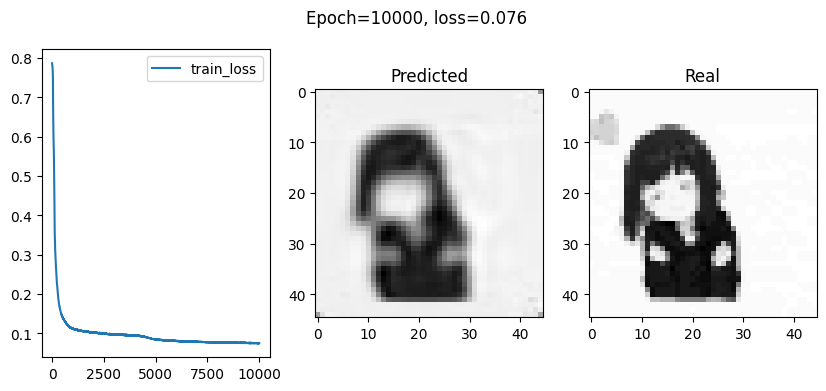

epoch : 20001/100000, recon loss = 0.06295267


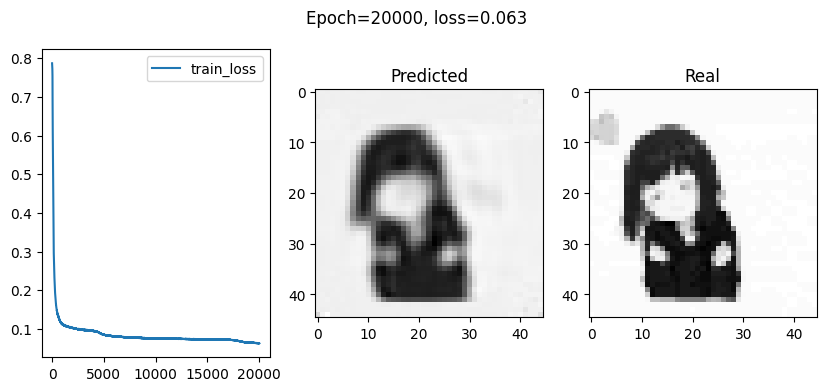

epoch : 30001/100000, recon loss = 0.05699556


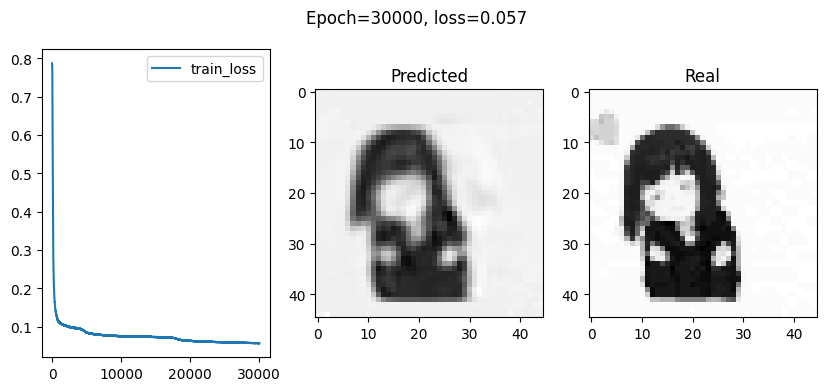

epoch : 40001/100000, recon loss = 0.05401888


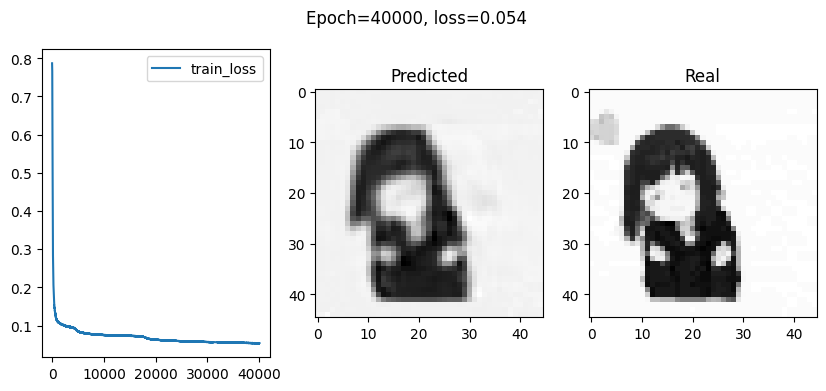

epoch : 50001/100000, recon loss = 0.05072118


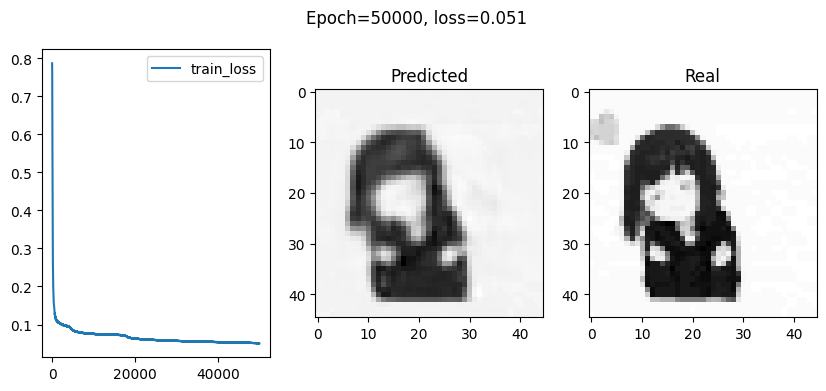

epoch : 60001/100000, recon loss = 0.04736254


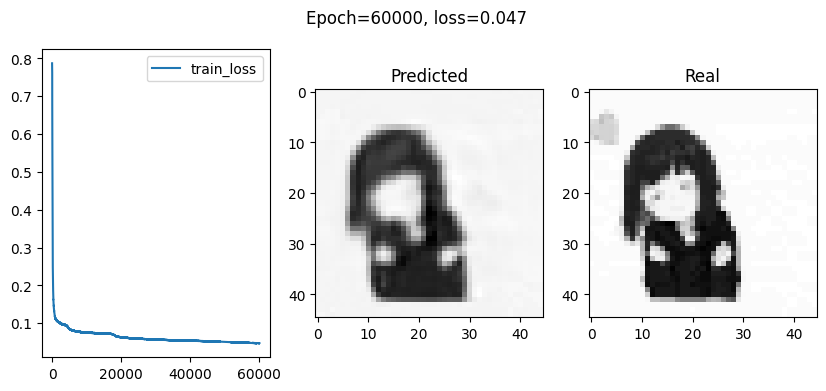

epoch : 70001/100000, recon loss = 0.04478543


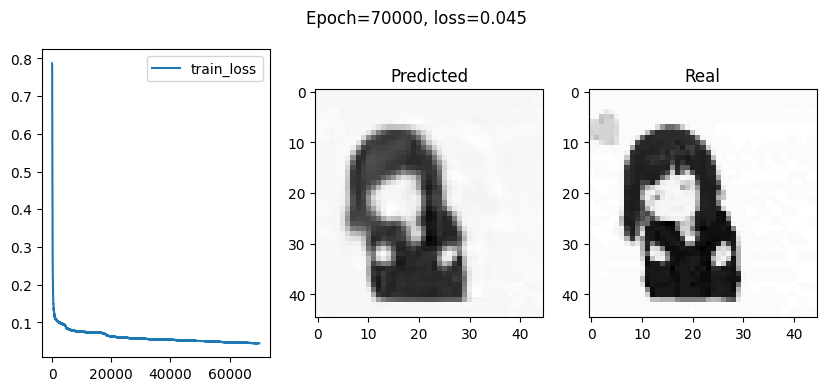

epoch : 80001/100000, recon loss = 0.04306928


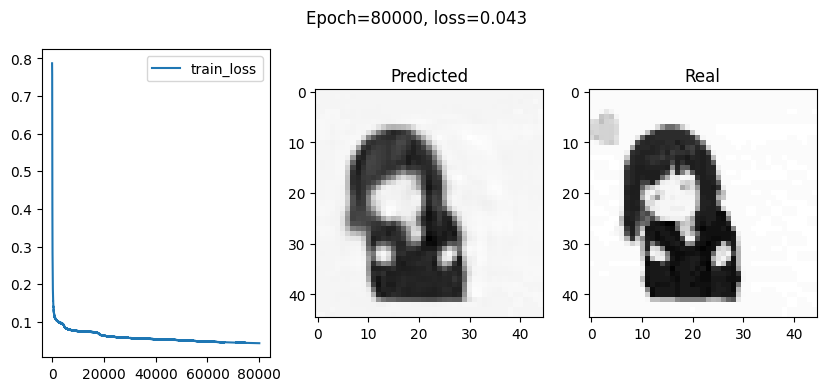

epoch : 90001/100000, recon loss = 0.04134887


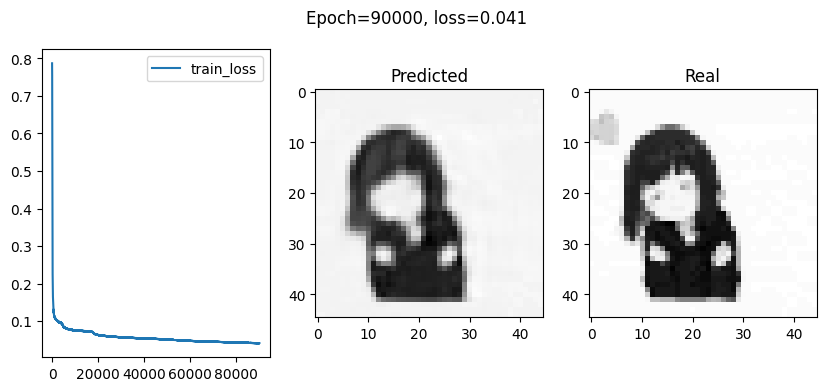

time spent: 484.15301537513733


In [47]:
from tqdm.auto import tqdm
plt.rcParams['figure.figsize'] = (10, 4)
from torch import nn
from torchcnnbuilder.models import ForecasterBase
import time
device='cuda'
# example of initialization
model = ForecasterBase(input_size=[45, 45],
                       in_time_points=20,
                       out_time_points=10,
                       n_layers=5,
                       finish_activation_function=nn.ReLU(inplace=True))
model=model.to(device)
epochs = 100000
batch_size = 500

dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()
losses = []
epochs_list = []

start = time.time()
for epoch in tqdm(range(epochs)):
    loss = 0
    
    for train_features, test_features in dataloader:
        train_features = train_features.to(device)
        test_features = test_features.to(device)
        
        optimizer.zero_grad()
        outputs = model(train_features)
    
        train_loss = criterion(outputs, test_features)
        
        train_loss.backward()
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(dataloader)
    
    losses.append(loss)
    epochs_list.append(epoch)
    
    
    if epoch % 10000 == 0 and epoch!=0:
        tqdm.write("epoch : {}/{}, recon loss = {:.8f}".format(epoch+1, epochs, loss))
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.plot(np.arange(len(losses)), losses, label='train_loss')
        ax1.legend()
        ax2.imshow(outputs.detach().cpu().numpy()[0][0], cmap='Greys_r')
        ax2.set_title('Predicted')
        ax3.imshow(test_features.detach().cpu().numpy()[0][0], cmap='Greys_r')
        ax3.set_title('Real')
        plt.suptitle(f'Epoch={epoch}, loss={round(losses[-1], 3)}')
        plt.show()


end = time.time()
print(f'time spent: {end-start}')

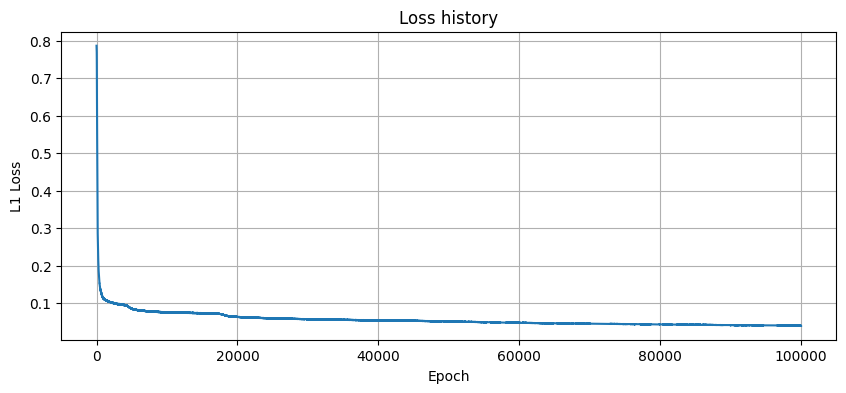

In [48]:
plt.plot(epochs_list, losses)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('Loss history')
plt.show()